In [45]:
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
from scalable_gps import kernels
from scalable_gps import thompson_utils

seed = 7
D = 1

kernel_name = "Matern32Kernel"
signal_scale = 1.0
length_scale = jnp.array([0.1])
noise_scale = 1e-3

kernel_init_fn = getattr(kernels, kernel_name)
kernel = kernel_init_fn({'signal_scale': signal_scale, 'length_scale': length_scale})

n_features = 1000
n_init = 10
n_friends = 50
n_homies = 15
n_besties = 1
n_samples = 7

optim_lr = 1e-3
optim_iters = 100

init_key = jax.random.PRNGKey(seed)
state = thompson_utils.init(init_key, D, kernel, n_features=n_features, n_init=n_init)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
### ExactGP
from scalable_gps.models.exact_gp_model import ExactGPModel

exact_gp = ExactGPModel(noise_scale=noise_scale, kernel=kernel)
alpha_map = exact_gp.compute_representer_weights(state.ds)
print(alpha_map.shape)

friends_key = jax.random.PRNGKey(42)
ds_friends = thompson_utils.find_friends(friends_key, state, n_friends)
L = thompson_utils.add_features(state.L, ds_friends.x, state.feature_fn)
print(L.shape)

samples_key = jax.random.PRNGKey(1337)
ds_friends.y, alpha_samples, w_samples = exact_gp.compute_posterior_samples(samples_key, n_samples, state.ds, ds_friends, use_rff=True, L=L, zero_mean=False)
print(ds_friends.y.shape, alpha_samples.shape, w_samples.shape)

acquisition_fn = thompson_utils.get_acquisition_fn(state, alpha_map, alpha_samples, w_samples, kernel.kernel_fn)

(10,)
(60, 1000)
(7, 50) (7, 10) (7, 1000)


In [47]:
# find homies
x_homies = thompson_utils.find_homies(ds_friends, n_homies)

# find bestie
x_besties, trace = thompson_utils.find_besties(x_homies, acquisition_fn,
                                               learning_rate=optim_lr,
                                               iterations=optim_iters,
                                               optim_trace=True,
                                               n_besties=n_besties)
# add bestie to ds
updated_state = thompson_utils.update_state(state, x_besties)

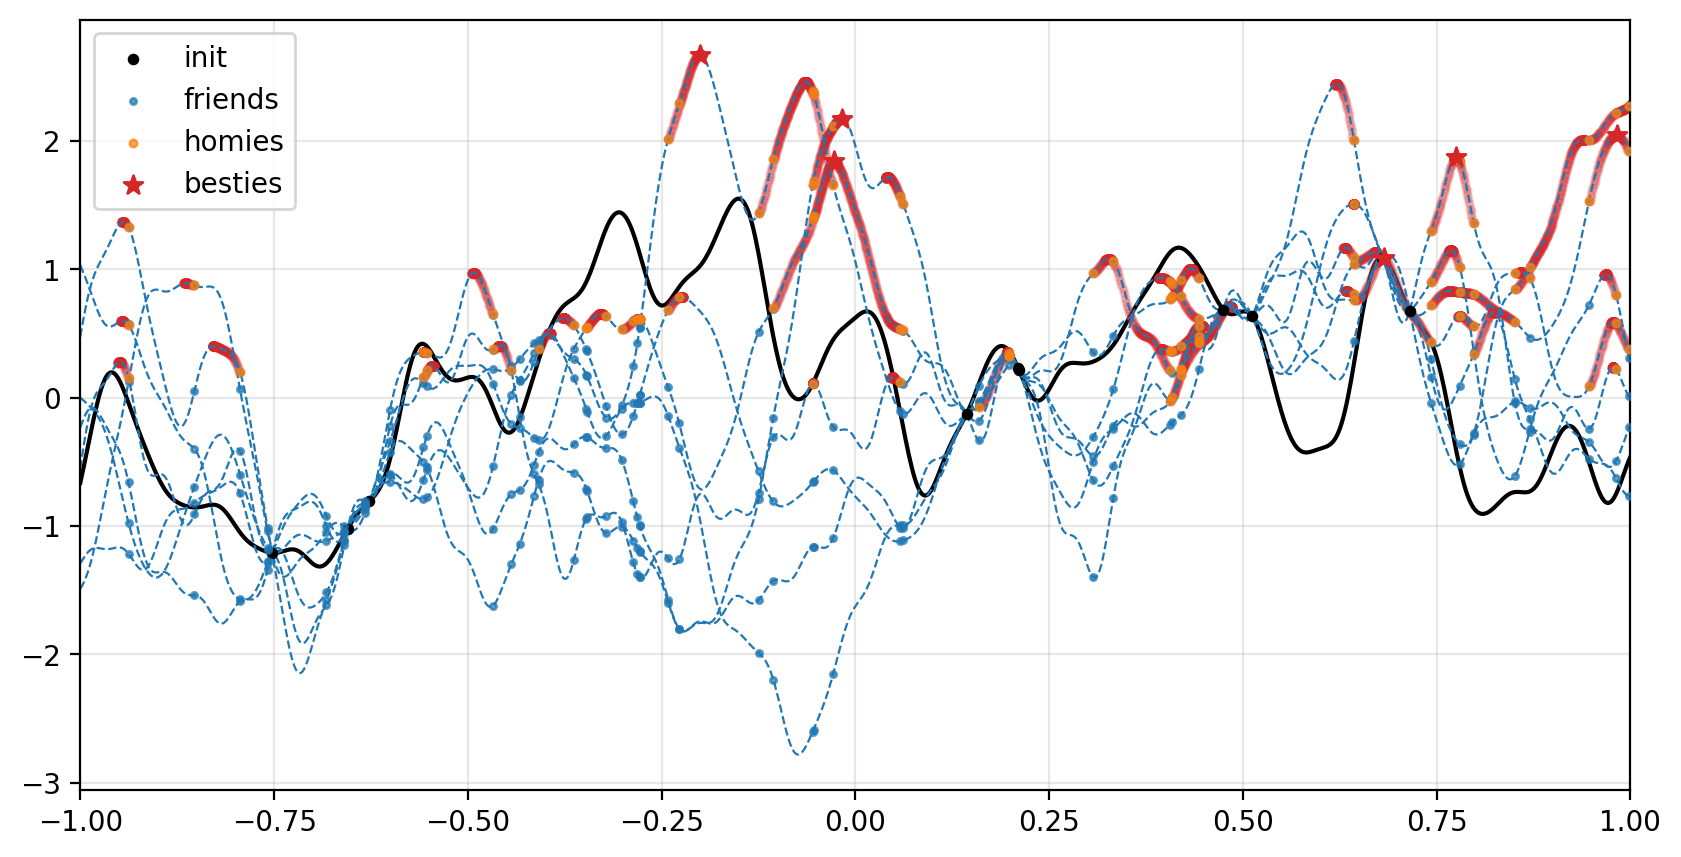

In [48]:
import matplotlib.pyplot as plt

n_plot = 1000
x_plot = jnp.linspace(-1, 1, num=n_plot)[:, None]

fig = plt.figure(dpi=200, figsize=[10, 5])
ax = fig.add_subplot(111)
ax.set_xlim(-1, 1)
ax.plot(x_plot, state.objective_fn(x_plot), color='k')
ax.scatter(state.ds.x, state.ds.y, color='k', marker='o', s=10, zorder=3, label='init')
ax.scatter(ds_friends.x.repeat(n_samples, axis=0), ds_friends.y.T.ravel(), color='tab:blue', marker='o', s=5, zorder=3, alpha=0.7, label='friends')
ax.scatter(x_homies, acquisition_fn(x_homies)[0], color='tab:orange', marker='o', s=7, zorder=3, alpha=0.7, label='homies')
for (x, y) in trace:
    ax.scatter(x, y, color='tab:red', marker='o', s=7, zorder=2, alpha=0.2)
ax.scatter(x_besties, acquisition_fn(x_besties)[0], color='tab:red', marker='*', s=50, zorder=4, label='besties')
ax.plot(x_plot, acquisition_fn(x_plot[None, :].repeat(n_samples, axis=0))[0].T, color='tab:blue', linestyle='--', linewidth=0.8)
ax.grid(alpha=0.3, zorder=0)
ax.legend()

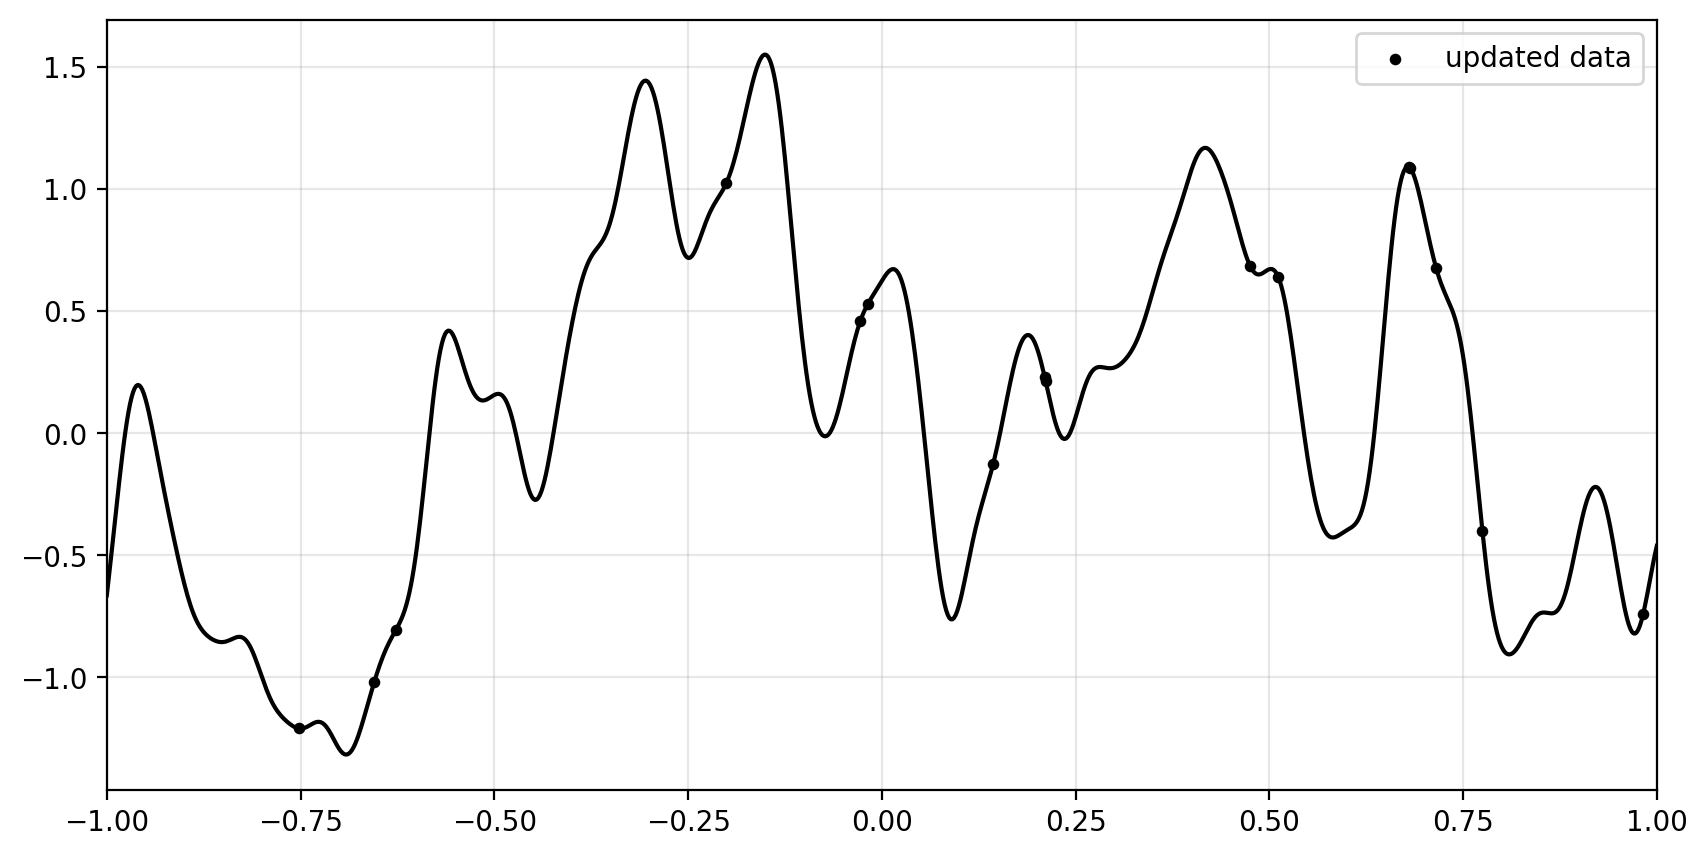

In [49]:
import matplotlib.pyplot as plt

n_plot = 1000
x_plot = jnp.linspace(-1, 1, num=n_plot)[:, None]

fig = plt.figure(dpi=200, figsize=[10, 5])
ax = fig.add_subplot(111)
ax.set_xlim(-1, 1)
ax.plot(x_plot, state.objective_fn(x_plot), color='k')
ax.scatter(updated_state.ds.x, updated_state.ds.y, color='k', marker='o', s=10, zorder=3, label='updated data')
ax.grid(alpha=0.3, zorder=0)
ax.legend()